<h1>Análise e Correlações do Preço do Frete na Importação</h1>
<hr>

## Google Colab

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import re

## Abertura do dados
---


### Importação Brasil
Link: [Ministério da Economia](https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip)

In [2]:
#df_importacao = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/IMP_COMPLETA.csv",sep=';')
df_importacao = pd.read_csv('../datasets/IMP_COMPLETA.csv',sep=';')
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36389808 entries, 0 to 36389807
Data columns (total 13 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CO_ANO      int64 
 1   CO_MES      int64 
 2   CO_NCM      int64 
 3   CO_UNID     int64 
 4   CO_PAIS     int64 
 5   SG_UF_NCM   object
 6   CO_VIA      int64 
 7   CO_URF      int64 
 8   QT_ESTAT    int64 
 9   KG_LIQUIDO  int64 
 10  VL_FOB      int64 
 11  VL_FRETE    int64 
 12  VL_SEGURO   int64 
dtypes: int64(12), object(1)
memory usage: 3.5+ GB


In [3]:
print(f'Menor ano: {df_importacao.CO_ANO.min()}\nMaior ano: {df_importacao.CO_ANO.max()}')

Menor ano: 1997
Maior ano: 2022


**Separando dados de 10 anos atrás (2012 - 2022)**

In [4]:
df_importacao = df_importacao[df_importacao.CO_ANO >= 2012]
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18689502 entries, 17700306 to 36389807
Data columns (total 13 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CO_ANO      int64 
 1   CO_MES      int64 
 2   CO_NCM      int64 
 3   CO_UNID     int64 
 4   CO_PAIS     int64 
 5   SG_UF_NCM   object
 6   CO_VIA      int64 
 7   CO_URF      int64 
 8   QT_ESTAT    int64 
 9   KG_LIQUIDO  int64 
 10  VL_FOB      int64 
 11  VL_FRETE    int64 
 12  VL_SEGURO   int64 
dtypes: int64(12), object(1)
memory usage: 1.9+ GB


## Tabelas auxiliares
---
Link: [Tabela Códigos](https://balanca.economia.gov.br/balanca/bd/tabelas/TABELAS_AUXILIARES.xlsx)

Indice Excel usado
* 1 (NO_SH4_POR): Classe pertencente ao produto
* 10 (CO_PAIS): País de origem do produto
* 14 (CO_VIA): Meio de transporte da mercadoria
* 15 (CO_URF): Local de chegada no Brasil da mercadoria
* 12 (SG_UF): Sigla do estado de origem


Da mesma forma, a formatação dos dados está correta e também não há dados nulos não havendo necessidade de tratá-los.

In [5]:
############ Tabela disponível no github ############

#url = "https://github.com/Migliorin/Comex_Data_Analysis/blob/main/datasets/TABELAS_AUXILIARES.xlsx?raw=true"
#xl_file = pd.ExcelFile(url)

#####################################################

xl_file = pd.ExcelFile('../datasets/TABELAS_AUXILIARES.xlsx')
df_pais = xl_file.parse('10')
df_ncm = xl_file.parse('1')
df_via = xl_file.parse('14')
df_urf = xl_file.parse('15')
df_uf = xl_file.parse('12')

## Substituição código
---
Para melhor análise e entedimento, será usado a tabela de códigos para substituir os códigos dentro da base bruta. Como as colunas de alguns códigos serão traduzidas, então serão retirados as seguintes colunas:

* CO_NCM
* CO_PAIS
* CO_VIA
* CO_URF
* SG_UF_NCM

**Variável final**: df

In [6]:
df = df_importacao.merge(df_ncm[['CO_NCM','NO_SH4_POR']],on='CO_NCM').copy()
df = df.merge(df_pais[['CO_PAIS','NO_PAIS']],on='CO_PAIS')
df = df.merge(df_urf[['CO_URF','NO_URF']],on='CO_URF')
df = df.merge(df_via[['CO_VIA','NO_VIA']],on='CO_VIA')

df.rename({'SG_UF_NCM':'SG_UF'},axis=1,inplace=True)

df = df.merge(df_uf[['SG_UF','NO_REGIAO']],on='SG_UF')

In [7]:
df.drop(['CO_NCM','CO_PAIS','CO_URF','CO_VIA'],axis=1,inplace=True)

## Dados nulos Importações
---
No dataset de Importações não há presença de valores nulos não havendo necessidade de tratá-los.

In [8]:
df.isnull().sum()

CO_ANO        0
CO_MES        0
CO_UNID       0
SG_UF         0
QT_ESTAT      0
KG_LIQUIDO    0
VL_FOB        0
VL_FRETE      0
VL_SEGURO     0
NO_SH4_POR    0
NO_PAIS       0
NO_URF        0
NO_VIA        0
NO_REGIAO     0
dtype: int64

## Visualização do dataset

In [9]:
df.head()

,CO_ANO,CO_MES,CO_UNID,SG_UF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO,NO_SH4_POR,NO_PAIS,NO_URF,NO_VIA,NO_REGIAO
0,2012,10,10,SP,0,0,134,24,0,"Fios, cabos (incluídos os cabos coaxiais) e ou...",Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,REGIAO SUDESTE
1,2012,9,10,SP,1,1,583,10,1,"Fios, cabos (incluídos os cabos coaxiais) e ou...",Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,REGIAO SUDESTE
2,2012,12,10,SP,1,1,722,10,0,"Fios, cabos (incluídos os cabos coaxiais) e ou...",Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,REGIAO SUDESTE
3,2012,8,10,SP,1,1,488,18,0,"Fios, cabos (incluídos os cabos coaxiais) e ou...",Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,REGIAO SUDESTE
4,2012,7,10,SP,1,1,1187,15,0,"Fios, cabos (incluídos os cabos coaxiais) e ou...",Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,REGIAO SUDESTE


## Visualização dos dados

### Países
---
Número de importações feitas para o Brasil listando os 15+ países de origem. De 1997 a 2022, os 5 países que mais exportaram para o Brasil foram:

1. Estados Unidos
2. China
3. Alemanha
4. Italia
5. Japão

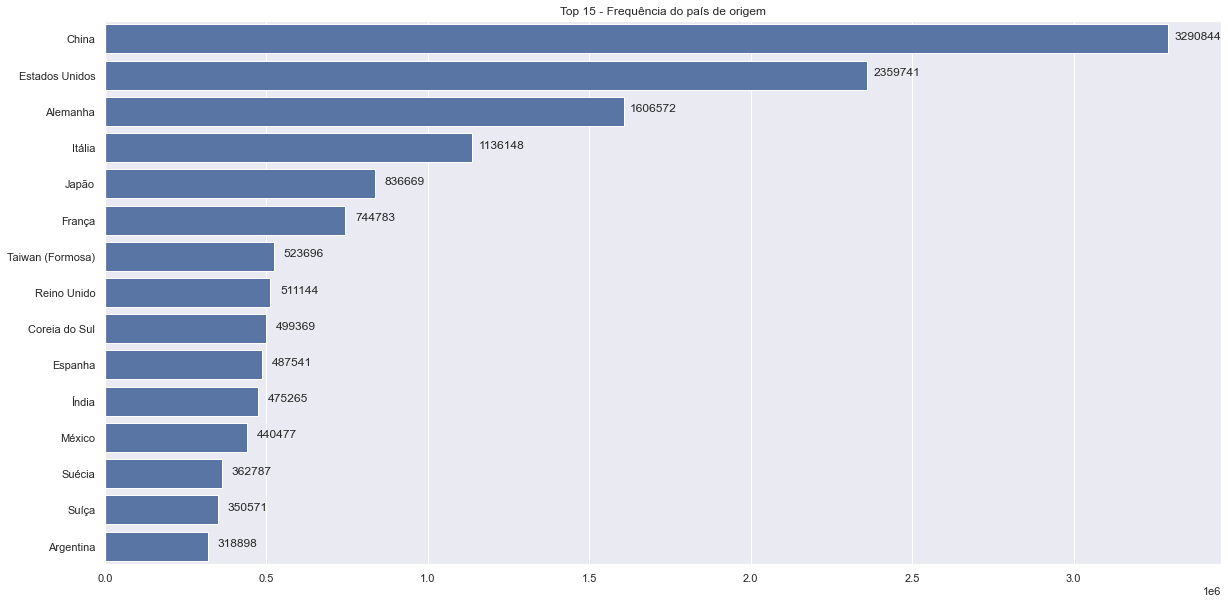

In [10]:
sns.set_theme(style="darkgrid")

# Contagem valores
count = df.NO_PAIS.value_counts()

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 10))
bar = sns.barplot(x=list(count)[:15], y=list(count.index)[:15],
            label="Total", color="b")

for p in bar.patches:
    bar.annotate(int(p.get_width()), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (30, -12), 
                   textcoords = 'offset points')
    

ax.set_title("Top 15 - Frequência do país de origem")
plt.show()

### Destino
---
Destino final das mercadorias predominando a região Sudeste como o principal destino, enquanto a região Norte fica em terceiro lugar.

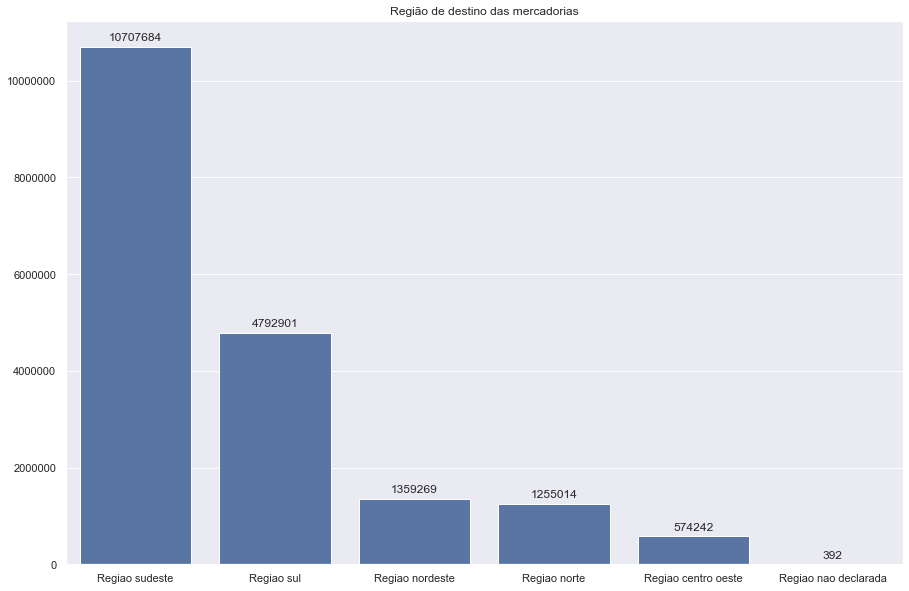

In [11]:
sns.set_theme(style="darkgrid")

# Contagem valores
count = df.NO_REGIAO.value_counts()

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 10))
bar = sns.barplot(y=list(count), x=[x.lower().capitalize() for x in count.index],
            label="Total", color="b")

for p in bar.patches:
    bar.annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    

ax.set_title("Região de destino das mercadorias")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))
plt.show()

## Vias de transporte
---

Abaixo mostra o gráfico da quantidade de vezes que as vias de transporte foram usadas e sua porcentagem em relação ao todo. As vias mais utilizadas são a **Aerea**, **Marítima** e **Rodoviária**. As vias de transporte dentro do dataset são:

1. Aerea
2. Maritima
3. Rodoviaria
4. Entrada/saida ficta
5. Postal
6. Meios proprios
7. Ferroviaria
8. Conduto/rede de transmissao
9. Fluvial
10. Courier
11. Lacustre

Para melhor visualização, as demais vias serão incluídas na categoria "Outros" sendo assim **Aerea**, **Marítima**, **Rodoviária** e **Outras** as novas categorias de vias.

**Contagem da quantidade**

In [12]:
# Contagem dos valores
count = df.NO_VIA.value_counts()

total = count.sum()

**Visão geral da quantidade**

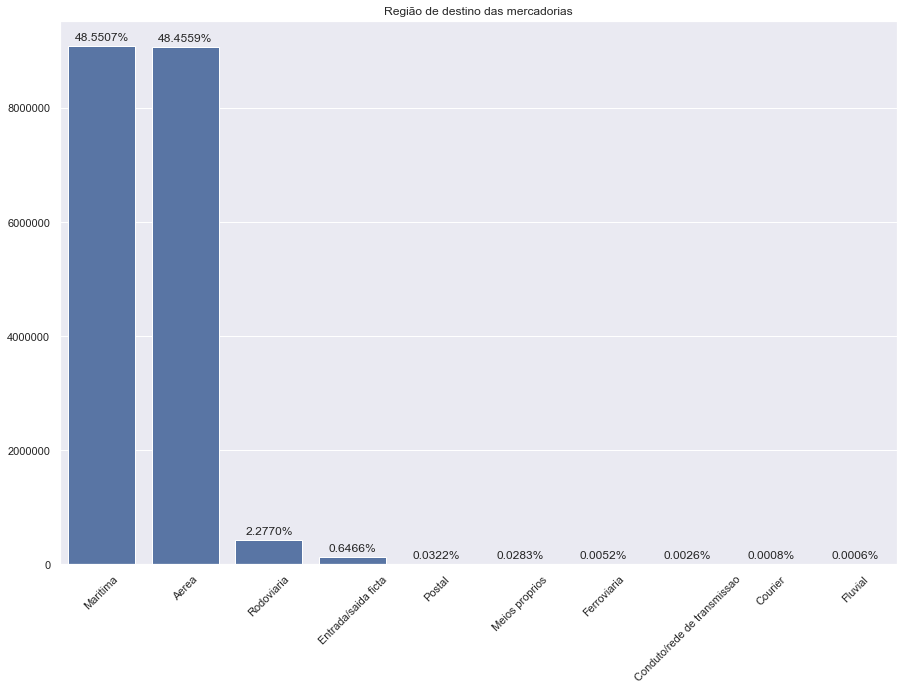

In [13]:
vias = pd.DataFrame(count)
vias.rename({'NO_VIA':'quantidade'},axis=1,inplace=True)

vias['porcentagem'] = vias.quantidade.apply(lambda x: x/total)

# Escolhendo o tema
sns.set_theme(style="darkgrid")


# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 10))
bar = sns.barplot(y=list(vias.quantidade), x=[x.lower().capitalize() for x  in vias.index],
            label="Total", color="b")

for i,p in enumerate(bar.patches):
    bar.annotate('{:.4f}%'.format((vias.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    

ax.set_title("Região de destino das mercadorias")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))
plt.xticks(rotation=45)
plt.show()

**Visão após a substituição**

In [14]:
# Mudanca dos nomes

outros_qtd = vias.iloc[3:,:].quantidade.sum()
vias = vias.iloc[:3]
df_outros = pd.DataFrame({'quantidade' : outros_qtd,'porcentagem':outros_qtd/total},index=['Outros'])
vias = pd.concat([vias,df_outros])

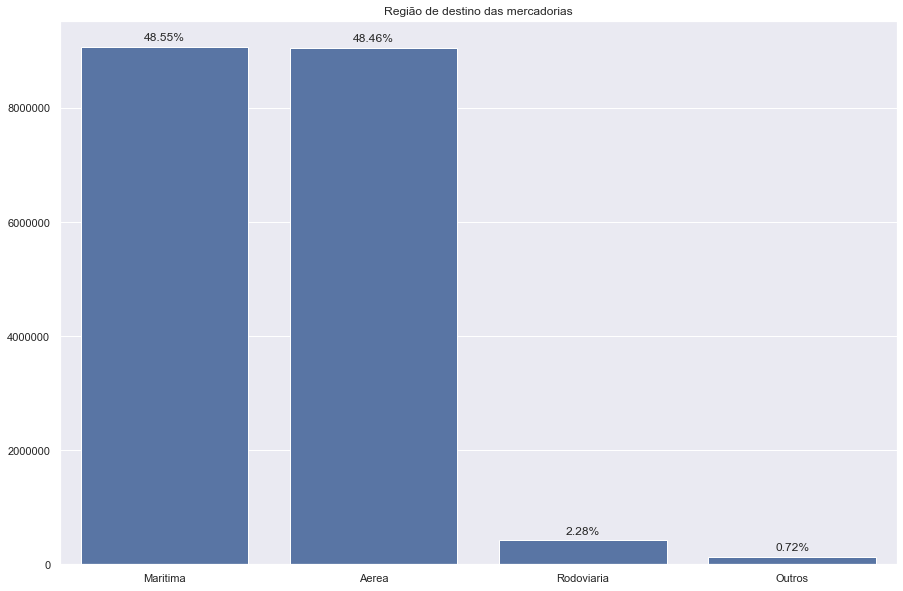

In [15]:
# Escolhendo o tema
sns.set_theme(style="darkgrid")


# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 10))
bar = sns.barplot(y=list(vias.quantidade), x=[x.lower().capitalize() for x  in vias.index],
            label="Total", color="b")

for i,p in enumerate(bar.patches):
    bar.annotate('{:.2f}%'.format((vias.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    

ax.set_title("Região de destino das mercadorias")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))
#plt.xticks(rotation=45)
plt.show()

**Mudança no dataset principal**

In [16]:
# Substituicao para a classe 'Outros'

df.NO_VIA = df.NO_VIA.apply(lambda x : 'OUTROS' if x not in ['AEREA','MARITIMA','RODOVIARIA'] else x)

## Produtos
---

Nesse gráfico é mostrado os 10 produtos mais importados desde de 1997 até 2022 e os meios em que os produtos foram importados.

Para uma melhor análise das proporções aplicou-se a função logarítmica pela presença de valores muito distantes para a quantidade transportada pelas vias

Os 10 produtos importados em ordem descrecente:

1. Condensadores elétricos, fixos, variáveis ou ajustáveis
2. Resistências elétricas (incluídos os reóstatos e os potenciómetros), exceto de aquecimento
3. Hulhas; briquetes, bolas e combustíveis sólidos semelhantes, obtidos a partir da hulha
4. Gás de petróleo e outros hidrocarbonetos gasosos
5. Adubos (fertilizantes) minerais ou químicos, potássicos
6. Díodos, transístores e dispositivos semelhantes com semicondutores; dispositivos fotossensíveis semicondutores, incluídas as células fotovoltaicas, mesmo montadas em módulos ou em painéis; díodos emissores de luz; cristais piezoelétricos montados
7. Trigo e mistura de trigo com centeio
8. Adubos (fertilizantes) minerais ou químicos, azotados
9. Aparelhos para interrupção, seccionamento, protecção, derivação, ligação ou conexão de circuitos elétricos (por exemplo: interruptores, comutadores, relés, corta-circuitos, eliminadores de onda, tomadas de corrente, machos e fêmeas, suportes para lâmpada
10. Adubos (fertilizantes) minerais ou químicos, contendo dois ou três dos seguintes elementos fertilizantes: azoto (nitrogénio), fósforo e potássio; outros adubos (fertilizantes); produtos do presente capítulo apresentados em tabletes ou formas semelhantes


**Conclusão análise**

Para uma análise mais precisa sobre o objetivo no qual é prever o valor do frete, limitou-se à classe de produto "Aparelhos elétricos para ligação, proteção ou conexão de circuitos" possuir mais produtos importados que pertecem à essa classe.

Dessa forma, separou-se essa classe das demais criando um novo DataFrame.

In [72]:
# Separando as 10 classes de produtos mais importadas em quantidade

aa = df[["NO_SH4_POR","QT_ESTAT"]].groupby(['NO_SH4_POR']).sum().sort_values(by=['QT_ESTAT'],ascending=False)
aa = aa.iloc[:5,:]
aa.reset_index(inplace=True)

# Salvando na variavel "total" a quantidade total importada na classe do produto
total = aa.copy()
total

,NO_SH4_POR,QT_ESTAT
0,"Condensadores elétricos, fixos, variáveis ou a...",398218493268
1,Resistências elétricas (incluídos os reóstatos...,283807009290
2,"Hulhas; briquetes, bolas e combustíveis sólido...",212635925857
3,Gás de petróleo e outros hidrocarbonetos gasosos,124567866834
4,"Adubos (fertilizantes) minerais ou químicos, p...",97726232959


In [73]:
# Agrupando pela classe dos produtos e pela via de transporte. Depois realizando o sort pela quantidade de
# modo descendente
aa = df.groupby(['NO_SH4_POR','NO_VIA']).sum().sort_values(by=['QT_ESTAT'],ascending=False)

# Resetando o index para que os nomes da classes fiquem nas linhas
aa.reset_index(inplace=True)

# Obtendo somente as colunas que serao usadas
aa = aa[["NO_SH4_POR","NO_VIA","QT_ESTAT"]]
aa

,NO_SH4_POR,NO_VIA,QT_ESTAT
0,"Condensadores elétricos, fixos, variáveis ou a...",AEREA,294476194194
1,"Hulhas; briquetes, bolas e combustíveis sólido...",MARITIMA,212606026125
2,Resistências elétricas (incluídos os reóstatos...,AEREA,172264821417
3,Resistências elétricas (incluídos os reóstatos...,MARITIMA,111534570171
4,"Condensadores elétricos, fixos, variáveis ou a...",MARITIMA,103737257267
...,...,...,...
4131,"Monofilamentos sintéticos, com pelo menos 67 d...",OUTROS,0
4132,"Marfim, osso, carapaça de tartaruga, chifre, p...",OUTROS,0
4133,"Produtos comestíveis de origem animal, não esp...",OUTROS,0
4134,"Chapas, folhas e tiras, de zinco",OUTROS,0


In [74]:
# Mergiando o dataframe com as quantiades estat de cada via com o dataframe total
final = aa.merge(total,on=['NO_SH4_POR'],how='left')

# Renomeando as colunas e ordenando com base no total
final = final.rename({'QT_ESTAT_x':'QT_VIA','QT_ESTAT_y':'TOTAL'},axis=1).sort_values(by=['TOTAL'],ascending=False)

# Obtendo somente as classes que queremos com base no dataframe total
final = final[final.NO_SH4_POR.apply(lambda x: True if x in list(total.NO_SH4_POR) else False)]

# # Obtendo somente as colunas que serao usadas
final = final[['NO_SH4_POR','NO_VIA','QT_VIA','TOTAL']]
final.reset_index(inplace=True)
final

,index,NO_SH4_POR,NO_VIA,QT_VIA,TOTAL
0,0,"Condensadores elétricos, fixos, variáveis ou a...",AEREA,294476194194,3.982185e+11
1,2511,"Condensadores elétricos, fixos, variáveis ou a...",OUTROS,114332,3.982185e+11
2,4,"Condensadores elétricos, fixos, variáveis ou a...",MARITIMA,103737257267,3.982185e+11
3,1311,"Condensadores elétricos, fixos, variáveis ou a...",RODOVIARIA,4927475,3.982185e+11
4,2,Resistências elétricas (incluídos os reóstatos...,AEREA,172264821417,2.838070e+11
5,3,Resistências elétricas (incluídos os reóstatos...,MARITIMA,111534570171,2.838070e+11
6,1300,Resistências elétricas (incluídos os reóstatos...,RODOVIARIA,5047357,2.838070e+11
7,1534,Resistências elétricas (incluídos os reóstatos...,OUTROS,2570345,2.838070e+11
8,2944,"Hulhas; briquetes, bolas e combustíveis sólido...",AEREA,25522,2.126359e+11
9,1,"Hulhas; briquetes, bolas e combustíveis sólido...",MARITIMA,212606026125,2.126359e+11


In [75]:
# Ordenando as classes 
produtos = list(set(final.NO_SH4_POR))
produtos.sort()

df_final = []

# iteracao para pegar no dataset mergiado as classes que nos interessa
for prod in produtos:
    aux = final[final.NO_SH4_POR == prod][['NO_VIA','QT_VIA']]
    df_final.append(pd.DataFrame([list(aux['QT_VIA'])],columns=list(aux['NO_VIA']),index=[prod]))

# Concatenando
df_final = pd.concat(df_final)

# Tratando dado nulo
df_final.fillna(0,inplace=True)

# Retirando o index
df_final.reset_index(inplace=True)

df_final

,index,RODOVIARIA,OUTROS,MARITIMA,AEREA
0,"Adubos (fertilizantes) minerais ou químicos, p...",33697060,1.200616e+07,97680507488,22248
1,"Condensadores elétricos, fixos, variáveis ou a...",4927475,1.143320e+05,103737257267,294476194194
2,Gás de petróleo e outros hidrocarbonetos gasosos,72265434,7.215500e+10,52340553330,49496
3,"Hulhas; briquetes, bolas e combustíveis sólido...",29874210,0.000000e+00,212606026125,25522
4,Resistências elétricas (incluídos os reóstatos...,5047357,2.570345e+06,111534570171,172264821417


In [76]:
def format_text(text:str):
    aux = ''
    count = 0
    for word in re.findall(r'\w+',text):
        if(count == 8):
            aux += word + '\n'
            count = 0
        else:
            aux += word + ' '
        count += 1
    return aux

In [77]:
df_final['index'] = df_final['index'].apply(lambda x: format_text(x))

soma = []

for row_ in df_final.iloc:
    soma.append(row_['AEREA'] + row_['RODOVIARIA']+row_['MARITIMA']+row_['OUTROS'])
df_final['total'] = soma

df_final.sort_values(by=['total'],ascending=True,inplace=True)

C:\Users\Lucas Migliorin\AppData\Local\Temp\ipykernel_9432\3640463511.py:27: RuntimeWarning: divide by zero encountered in log
  ax.barh(row_["index"],np.log(row_["OUTROS"]), left=np.log(row_["AEREA"]) + np.log(row_["RODOVIARIA"]) + np.log(row_["MARITIMA"]), color="r")
C:\Users\Lucas Migliorin\AppData\Local\Temp\ipykernel_9432\3640463511.py:29: RuntimeWarning: divide by zero encountered in log
  (np.log(row_["AEREA"]) + np.log(row_["RODOVIARIA"]) + np.log(row_["MARITIMA"]) + np.log(row_["OUTROS"])) -7
posx and posy should be finite values
C:\Python310\lib\site-packages\matplotlib\transforms.py:378: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


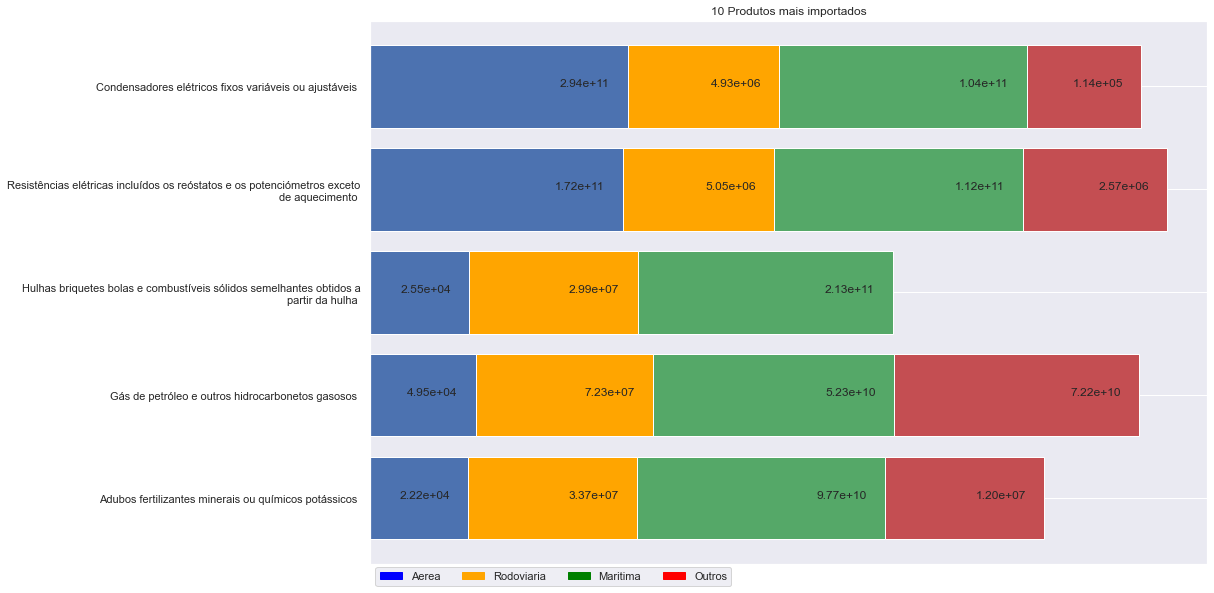

In [78]:
# Escolhendo o tema
sns.set_theme(style="darkgrid")


# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 10))

for i,row_ in enumerate(df_final.iloc):
    bar = ax.barh(row_['index'],np.log(row_["AEREA"]), color="b")
    ax.text(
        np.log(row_["AEREA"]) -7,
        i,
        np.format_float_scientific(row_["AEREA"], unique=False, precision=2))

    ax.barh(row_["index"],np.log(row_["RODOVIARIA"]), left=np.log(row_["AEREA"]), color="orange")
    ax.text(
        (np.log(row_["AEREA"]) + np.log(row_["RODOVIARIA"])) -7
        ,i
        ,np.format_float_scientific(row_["RODOVIARIA"], unique=False, precision=2))

    ax.barh(row_["index"],np.log(row_["MARITIMA"]), left=np.log(row_["AEREA"]) + np.log(row_["RODOVIARIA"]), color="g")
    ax.text(
        (np.log(row_["AEREA"]) + np.log(row_["RODOVIARIA"]) + np.log(row_["MARITIMA"])) -7
        ,i
        ,np.format_float_scientific(row_["MARITIMA"], unique=False, precision=2))

    ax.barh(row_["index"],np.log(row_["OUTROS"]), left=np.log(row_["AEREA"]) + np.log(row_["RODOVIARIA"]) + np.log(row_["MARITIMA"]), color="r")
    ax.text(
        (np.log(row_["AEREA"]) + np.log(row_["RODOVIARIA"]) + np.log(row_["MARITIMA"]) + np.log(row_["OUTROS"])) -7
        ,i
        ,np.format_float_scientific(row_["OUTROS"], unique=False, precision=2))

#plt.legend()
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
ax.xaxis.set_visible(False)

plt.legend(handles=[
    mpatches.Patch(color='blue', label='Aerea'),
    mpatches.Patch(color='orange', label='Rodoviaria'),
    mpatches.Patch(color='green', label='Maritima'),
    mpatches.Patch(color='red', label='Outros')
],loc='lower left',ncol=4, bbox_to_anchor=(0, -0.05))

plt.title('10 Produtos mais importados')
plt.show()

In [79]:
posi = []
for i,sh in tqdm(enumerate(df.NO_SH4_POR),total=len(df.NO_SH4_POR)):
    if(sh in list(total.NO_SH4_POR)):
        posi.append(i)

# Exportando
df_importacao.iloc[posi].to_csv('../datasets/classe_produto.csv',index=False)

  0%|          | 0/18689502 [00:00<?, ?it/s]

In [52]:
df_importacao[["CO_NCM","QT_ESTAT"]].groupby(['CO_NCM']).sum().sort_values(by=['QT_ESTAT'],ascending=False).index[0]

85322410

In [54]:
df_importacao[df_importacao.CO_NCM == 85322410].to_csv('../datasets/teste.csv',index=False)

## Dolar Série Histórica
---
Após a análise e separação da mercadoria, escolheu-se a variação da cotação do dolar para investigar se há alguma relação entre ela e o preço do frete do produto.

A base de dados foi retirada do Centro de Estudos Avançados em Economia Aplicada (CEPEA) -- Universidade de São Paulo (USP) -- contendo variações da cotação de 1996 à 2022/01

Link: [Dolar Serie Historica](https://www.cepea.esalq.usp.br/br/serie-de-preco/dolar.aspx)

In [25]:
df_dolar = pd.read_csv("../datasets/export_series_dolar.csv")
df_dolar.columns = ['data','valor']
df_dolar = df_dolar.iloc[:-1,:]
df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6397 entries, 0 to 6396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    6397 non-null   object
 1   valor   6397 non-null   object
dtypes: object(2)
memory usage: 100.1+ KB


## Análise Gráfica Dolar
---

In [26]:
df_dolar.data = pd.to_datetime(df_dolar.data.apply(lambda x: "-".join(x.split('/')[::-1])))

df_dolar.valor = df_dolar.valor.apply(lambda x: float(x.replace(',','.')))

In [27]:
ano = []
mes = []
for data in df_dolar.data:
    ano.append(int(data.year))
    mes.append(int(data.month))

df_dolar['ano'] = ano
df_dolar['mes'] = mes

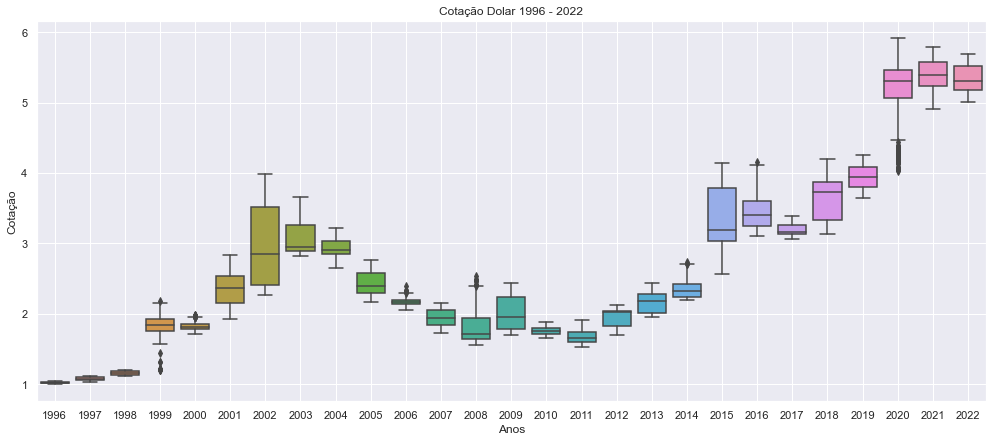

In [28]:
# Configurando tema
sns.set_theme(style="darkgrid")

# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(17,7))

sns.boxplot(data=df_dolar[['ano','valor']],y='valor',x='ano')
ax.set_title("Cotação Dolar 1996 - 2022")
ax.set_ylabel("Cotação")
ax.set_xlabel("Anos")
plt.grid(True)

plt.show()

## Unindo Datasets - Dolar e Importações
---
Para inverstigar uma correlação entre os dados de importações e a cotação do dolar, uniu-se a base de dados de **Importações** do produto "85322410" com a do **Dolar**.

In [110]:
# Importacao
#df_produto = pd.read_csv('../datasets/85322410.csv')
df_produto = pd.read_csv('../datasets/teste.csv')

# Dolar
#df_dolar = pd.read_csv("../datasets/export_series_dolar.csv")
df_dolar = pd.read_csv("../datasets/export_series_dolar.csv")
df_dolar.columns = ['data','valor']
df_dolar = df_dolar.iloc[:-1,:]

**Removendo 'Unamed: 0'**

In [111]:
if('Unnamed: 0' in df_produto.columns):
    df_produto.drop(['Unnamed: 0'],axis=1,inplace=True)

**Tratamento da variável "data" para criar duas novas colunas para que seja possível realizar o merge entre os DataFrames**

In [112]:
df_dolar.data = pd.to_datetime(df_dolar.data.apply(lambda x: "-".join(x.split('/')[::-1])))

df_dolar.valor = df_dolar.valor.apply(lambda x: float(x.replace(',','.')))

ano = []
mes = []
for data in df_dolar.data:
    ano.append(int(data.year))
    mes.append(int(data.month))

df_dolar['ano'] = ano
df_dolar['mes'] = mes

**Agrupando por ano e mes e obtendo suas respectivas médias**

In [113]:
df_dolar = df_dolar.groupby(['ano','mes']).mean()

df_dolar.reset_index(inplace=True)

In [114]:
df_dolar.reset_index(inplace=True)

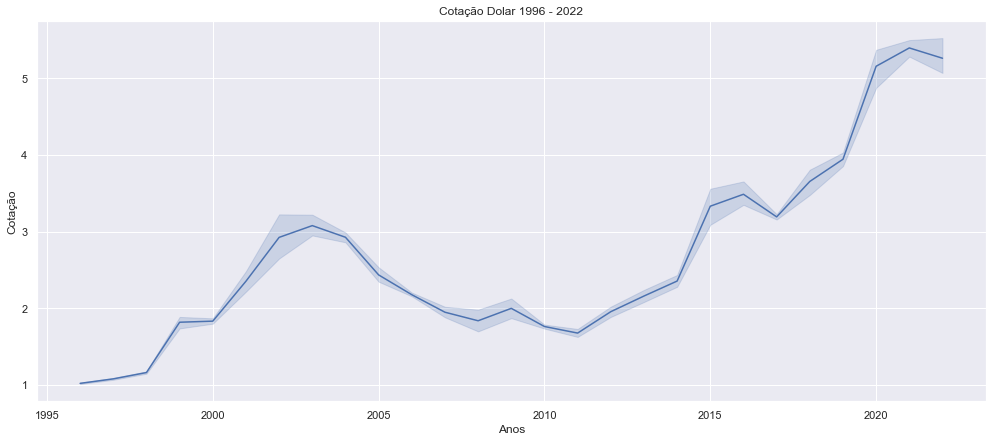

In [115]:
# Configurando tema
sns.set_theme(style="darkgrid")

# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(17,7))

sns.lineplot(data=df_dolar[['ano','valor']],y='valor',x='ano')
ax.set_title("Cotação Dolar 1996 - 2022")
ax.set_ylabel("Cotação")
ax.set_xlabel("Anos")
plt.grid(True)

plt.show()

**Mergiando os datasets**

In [116]:
df_produto = df_produto.merge(df_dolar,left_on=['CO_ANO','CO_MES'],right_on=['ano','mes'])

In [117]:
df_produto.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO,index,ano,mes,valor
0,2012,2,85322410,11,161,BA,4,517700,345000,13,2760,163,2,188,2012,2,1.717316
1,2012,2,85322410,11,455,RS,4,1017600,598000,107,6634,994,20,188,2012,2,1.717316
2,2012,2,85322410,11,687,SP,4,817700,552000,8,2740,188,6,188,2012,2,1.717316
3,2012,2,85322410,11,741,AM,4,227700,49351200,5184,68099,50337,61,188,2012,2,1.717316
4,2012,2,85322410,11,190,SP,1,817800,6228000,1786,15096,1325,12,188,2012,2,1.717316


**Colunas a serem removidas**

* CO_NCM
* CO_UNID
* index
* mes
* ano

Por ter sido especificado a mercadoria, não há necessidade de manter essas colunas na tabela e também por outras serem de identificação da posição na tabela anterior. Além disso, a renomeação de "valor" para "COTACAO" a fim de referenciar à variação do dolar naquele período.

In [118]:
df_produto.drop(['ano','mes','CO_NCM','CO_UNID','index'],axis=1,inplace=True)
df_produto.rename({'valor':'COTACAO'},axis=1,inplace=True)

**Removendo valores de frete iguais a 0**

In [119]:
df_produto = df_produto[df_produto.VL_FRETE != 0]
df_produto.reset_index(drop=True,inplace=True)

**Mapeando as SG_UF_NCM para números**

É necessário mapear para que o cálculo das correlações seja possível

In [120]:
def mudanca_uf(df_base:pd.DataFrame):
    aux_dict = dict(zip(list(df_base.SG_UF_NCM.value_counts().index),range(len(df_base.SG_UF_NCM.value_counts()))))
    try:
        df_base.SG_UF_NCM = df_base.SG_UF_NCM.apply(lambda x: aux_dict[x])
    except:
        pass

mudanca_uf(df_produto)

In [121]:
df_produto.head()

,CO_ANO,CO_MES,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO,COTACAO
0,2012,2,161,6,4,517700,345000,13,2760,163,2,1.717316
1,2012,2,455,4,4,1017600,598000,107,6634,994,20,1.717316
2,2012,2,687,0,4,817700,552000,8,2740,188,6,1.717316
3,2012,2,741,1,4,227700,49351200,5184,68099,50337,61,1.717316
4,2012,2,190,0,1,817800,6228000,1786,15096,1325,12,1.717316


## Investigação Correlações
---

O Heatmap é um gráfico aconselhável para visualizar as correlações. No caso, analisou-se o nível de correlação com foco no Valor do Frete.

In [122]:
df_produto = df_produto[df_produto.QT_ESTAT != 0]
df_produto = df_produto[df_produto.KG_LIQUIDO != 0]

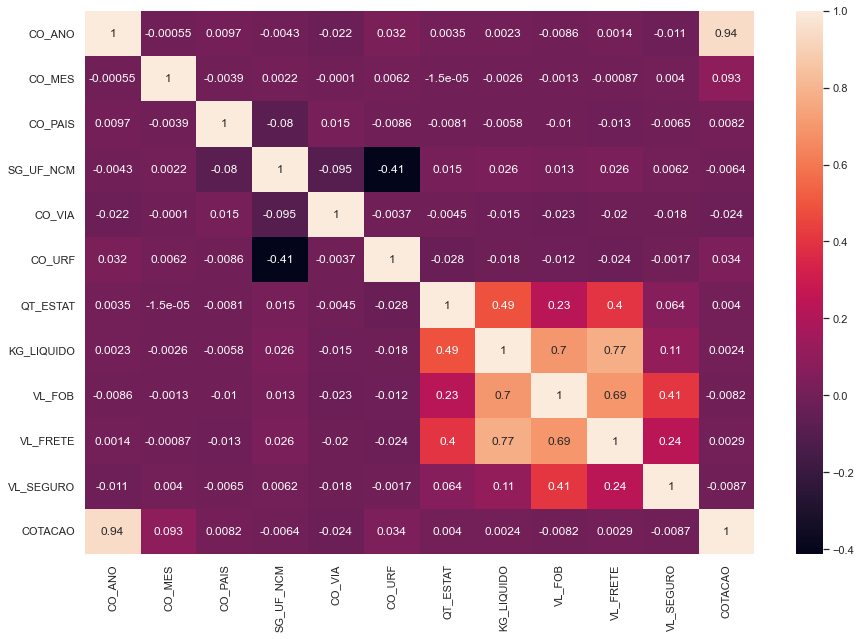

In [109]:
with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(df_produto.corr(),annot=True)
    plt.savefig("relacao_com_classes")

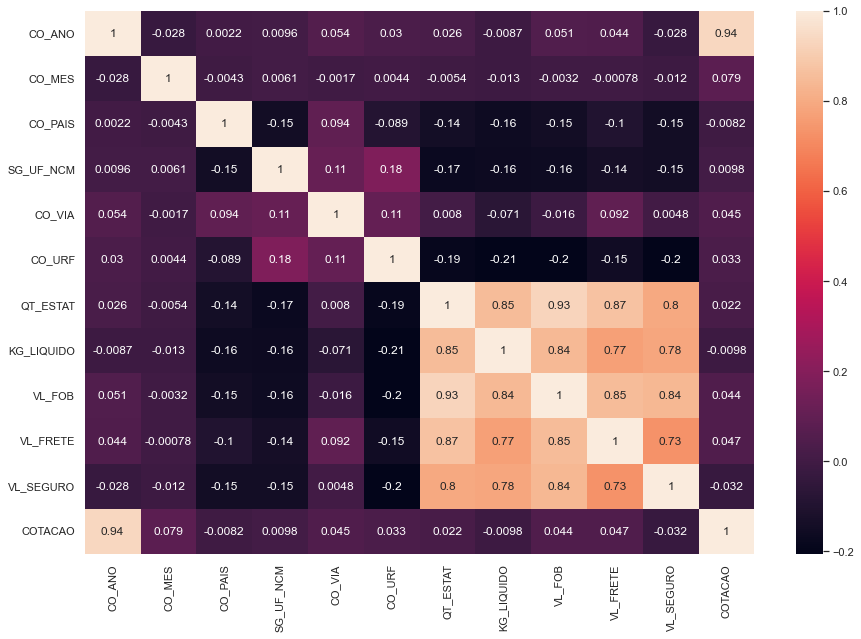

In [124]:
with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(df_produto.corr(),annot=True)
    plt.savefig("relacao_unico")

## Análise Gráfica Correlações

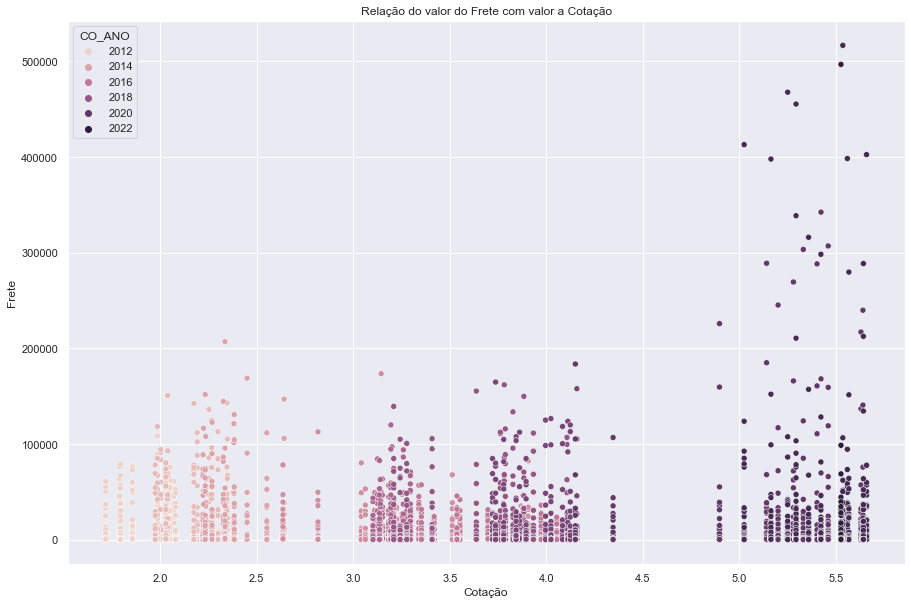

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='COTACAO',y='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Cotação')
ax.set_ylabel('Frete')

ax.set_title('Relação do valor do Frete com valor a Cotação')

plt.show()

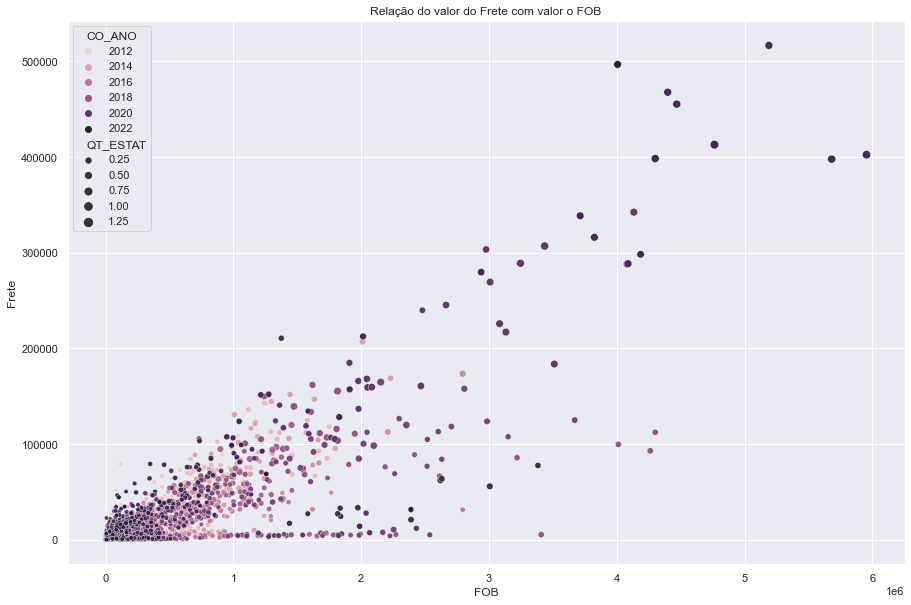

In [70]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='VL_FOB',y='VL_FRETE',size='QT_ESTAT',hue='CO_ANO')
ax.set_ylabel('Frete')
ax.set_xlabel('FOB')

ax.set_title('Relação do valor do Frete com valor o FOB')

plt.show()

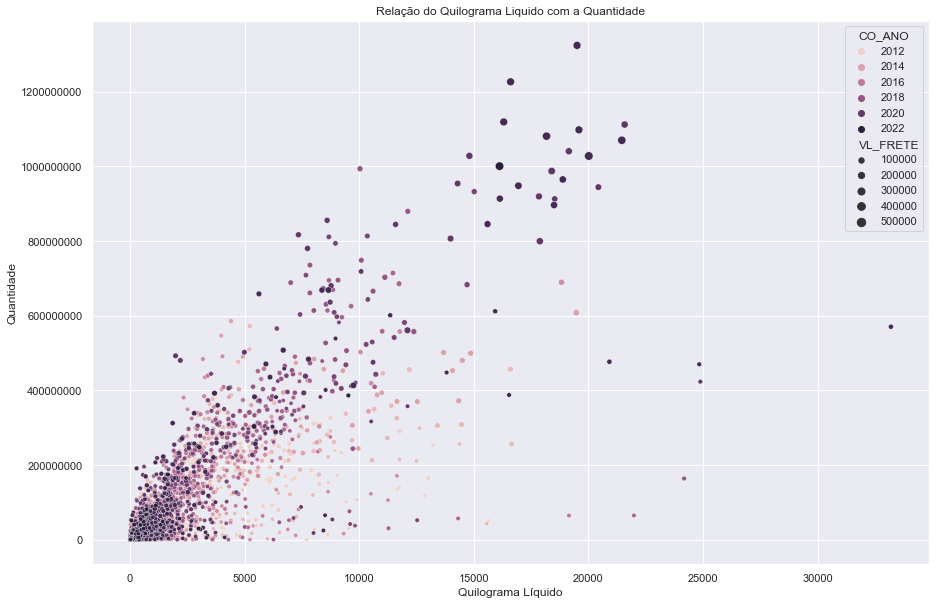

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.scatterplot(data=df_produto,x='KG_LIQUIDO',y='QT_ESTAT',size='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Quilograma Líquido')
ax.set_ylabel('Quantidade')

ax.set_title('Relação do Quilograma Liquido com a Quantidade')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))

## Aprendizado de Máquina
---

**Separando dados para treino e teste**

In [ ]:
from sklearn.model_selection import train_test_split

X, y = df_produto.drop(['VL_FRETE'],axis=1), df_produto.VL_FRETE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

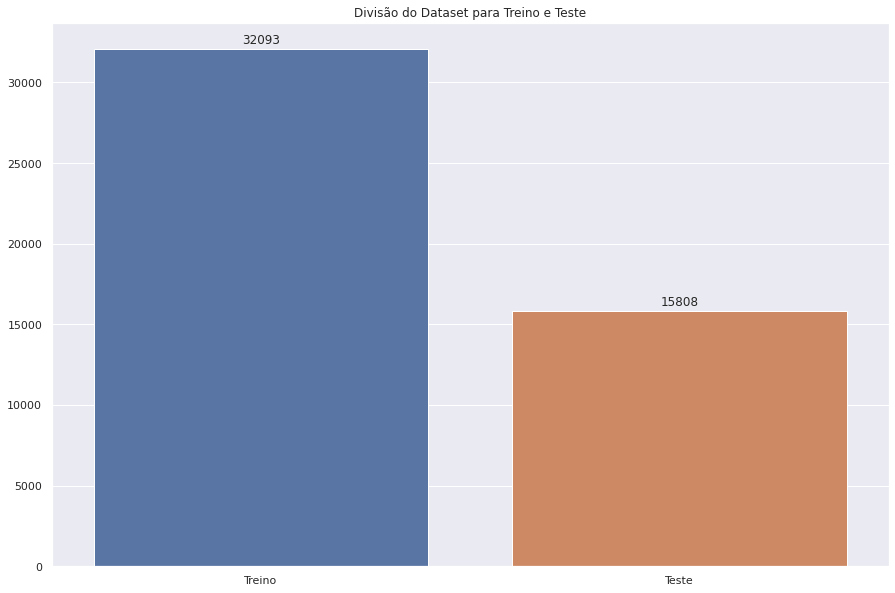

In [ ]:
# Configurando Tema
sns.set_theme(style="darkgrid")

# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(15,10))
bar = sns.barplot(y=[X_train.shape[0],X_test.shape[0]],x=['Treino','Teste'])

for p in bar.patches:
    bar.annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
ax.set_title("Divisão do Dataset para Treino e Teste")
plt.show()

## Treinamento

In [ ]:
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [ ]:
def treinamento_metricas(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    predict = clf.predict(X_test)
    r2 = r2_score(y_test, predict)
    mae = median_absolute_error(y_test, predict)
    print(f'\nR2: {r2}\nMAE: {mae}\n')

    soma = 0
    regr_y_test = []
    for val in y_test:
        soma += val
        regr_y_test.append(soma)

    soma = 0
    regr_y_predict = []
    for val in clf.predict(X_test):
        soma += val
        regr_y_predict.append(soma)

    # Configurando Tema
    sns.set_theme(style="darkgrid")

    # Configurando grafico
    fig, ax = plt.subplots(figsize=(15,10))

    plt.plot(range(len(regr_y_test)),regr_y_test,label='Gabarito')

    plt.plot(range(len(regr_y_predict)),regr_y_predict,label='Predição')

    ax.set_title('Reta de predição e gabarito')

    plt.legend()
    plt.show()
    

## Support Vector Machine

In [ ]:
from sklearn.svm import SVR
svm = SVR(verbose=True)

[LibSVM]
R2: 0.008986784766757405
MAE: 83.68398140119098



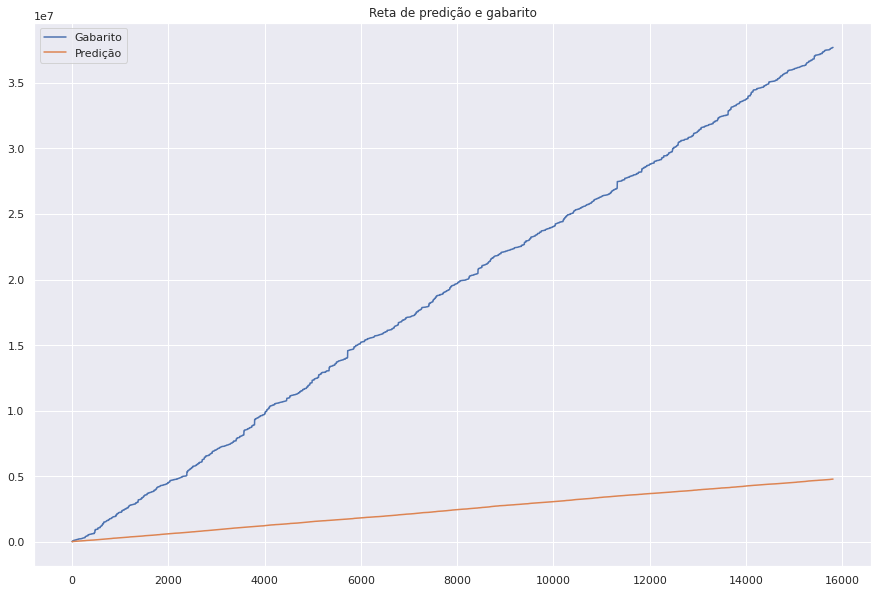

In [ ]:
treinamento_metricas(svm,X_train, X_test, y_train, y_test)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()


R2: 0.7550720159396431
MAE: 490.78762499932054



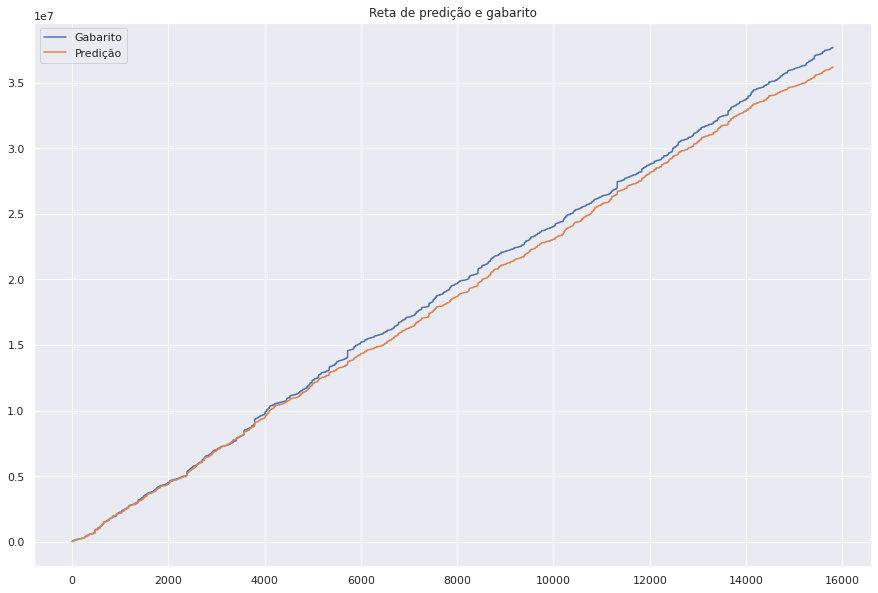

In [ ]:
treinamento_metricas(reg,X_train, X_test, y_train, y_test)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



R2: -6.745075287297893
MAE: 123.0



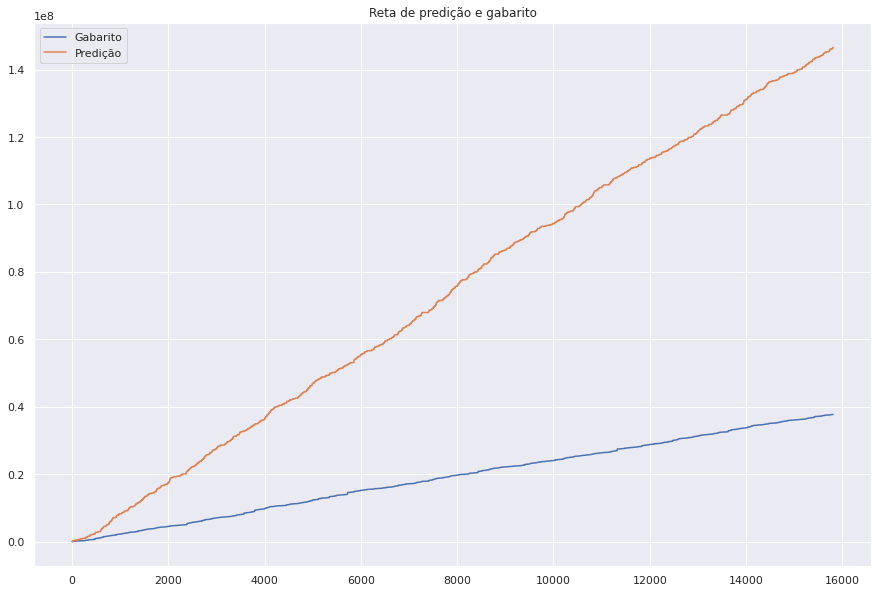

In [ ]:
treinamento_metricas(lreg,X_train, X_test, y_train, y_test)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor()


R2: 0.9287078262871042
MAE: 68.5



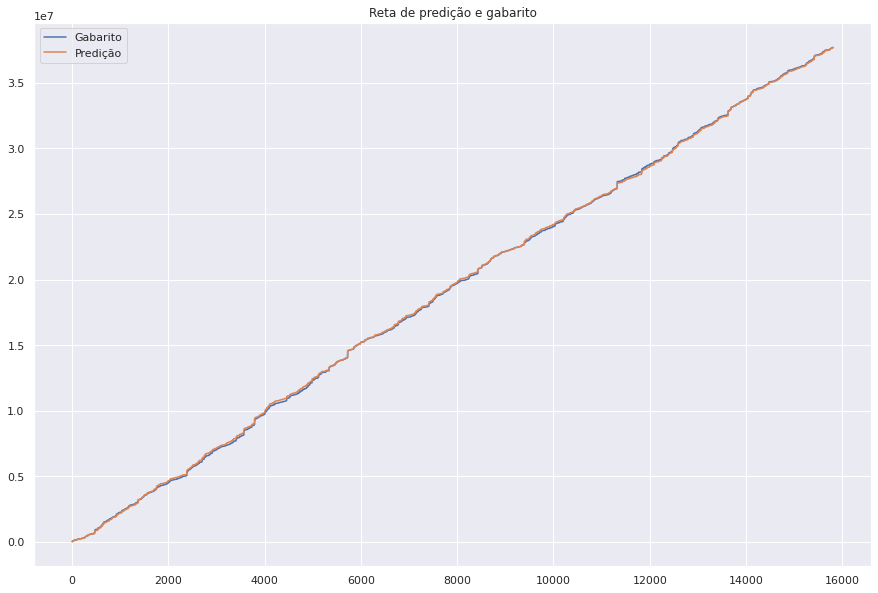

In [ ]:
treinamento_metricas(tree,X_train, X_test, y_train, y_test)

## K-Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor()


R2: 0.7679934388397436
MAE: 130.8



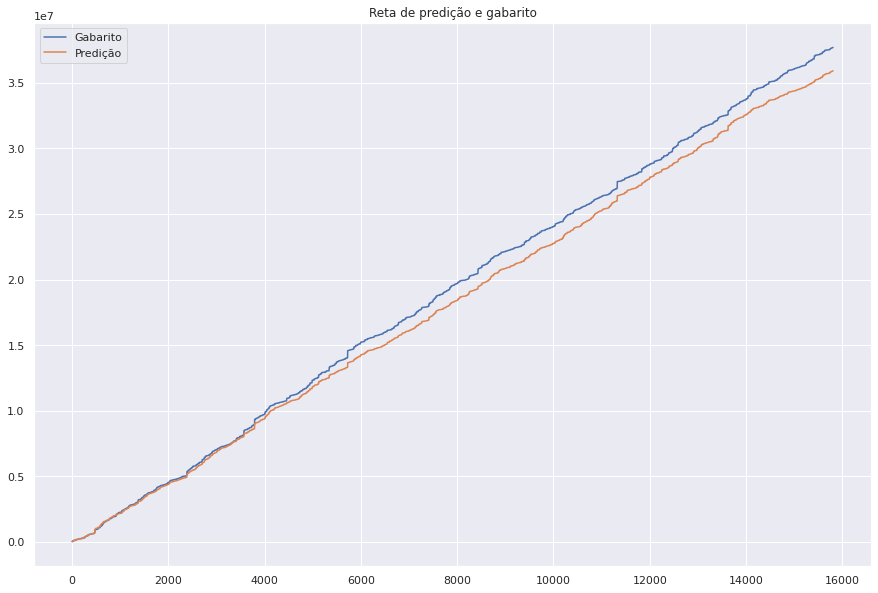

In [ ]:
treinamento_metricas(knn,X_train, X_test, y_train, y_test)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(random_state=42)


R2: 0.9578115151906679
MAE: 60.440000000000005



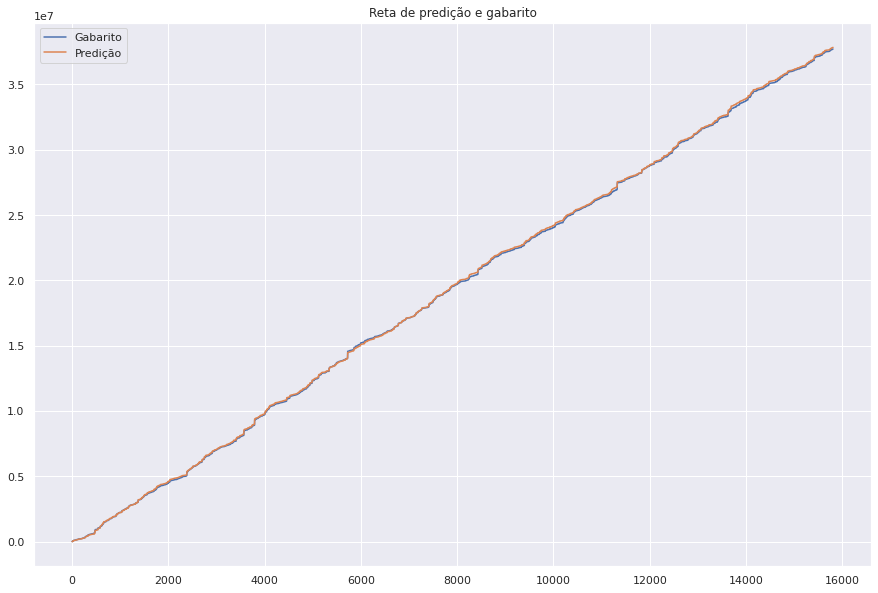

In [ ]:
treinamento_metricas(rfr,X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['squared_error', 'absolute_error', 'poisson']
}
CV_rfc = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:


CV_rfc.best_params_

